# Modélisations.

# Table des matières  <a id="sommaire" name="sommaire"></a>

**[I. Préparation des jeux d'entraînement et de test](#M1)**

**[II. Comparaison des performances de modèles](#M2)**
        
**[III. Optimisation des paramètres](#M3)**

**[IV. Evaluation de la prédiction des modèles](#M4)**

**[V. Calcul du scoring](#M5)**

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn

from scipy.stats import norm, skew
from scipy import stats
import statsmodels.api as sm

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve
from sklearn.metrics import f1_score, precision_score, recall_score, fbeta_score

In [2]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_row', 100)
plt.rcParams['font.size'] = 17

<a href="#sommaire">Retour au sommaire</a>
# I. Préparation des jeux d'entraînement et de test<a name="M1"></a>

In [3]:
# On récupére le dataset déjà dummisés:
dataset = pd.read_csv('Fichiers\dataset3.csv', sep = ',')
dataset

,churn,id_client,genre,espace_client_web,assurance_vie,banque_principale,anciennete_mois,compte_epargne,compte_courant,compte_joint,PEA,assurance_auto,assurance_habitation,credit_immo,type,compte_titres,agios_6mois,age,var_0,credit_autres_consommation,credit_autres_permanent,cartes_bancaires_medium,methode_contact_mail,methode_contact_sms,methode_contact_telephone,segment_client_A2,segment_client_A3,segment_client_A4,segment_client_B1,segment_client_B2,segment_client_B3,segment_client_B4,segment_client_C1,segment_client_C2,segment_client_C3,segment_client_C4,segment_client_D1,segment_client_D2,segment_client_D3,branche_NORD-EST,branche_NORD-OUEST,branche_OUTRE-MER,branche_SUD-EST,branche_SUD-OUEST
0,0,3463,1,0.0,0,0,37.0,1,1,0,0,0,1,0,1,1,91.15,30.0,3788.182745,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1,1463,0,0.0,0,0,4.0,1,0,0,0,0,0,0,1,0,70.40,32.0,5108.994106,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,688,1,0.0,0,0,52.0,0,0,1,0,0,0,0,0,0,30.10,57.0,13927.908142,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,2478,1,0.0,0,0,4.0,1,0,0,0,0,0,0,1,0,44.55,27.0,6609.031122,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
4,0,242,0,0.0,1,1,41.0,1,1,0,0,1,1,1,0,1,74.70,71.0,3582.799035,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3130,0,782,1,0.0,1,1,27.0,1,1,1,0,0,0,0,1,1,54.75,26.0,7423.819318,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
3131,0,5773,0,0.0,0,0,35.0,1,1,1,1,0,0,0,1,0,60.55,54.0,7788.303670,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3132,0,6801,0,0.0,1,1,19.0,1,0,0,0,1,0,1,0,1,89.35,43.0,11304.091638,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3133,0,3548,1,0.0,0,0,71.0,1,1,0,0,1,0,1,0,0,97.65,65.0,11727.651032,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


In [4]:
# On ne garde que les indicateurs prépondérants trouvés dans le 1er notebook:
dataset = dataset[['churn', 'id_client', 'anciennete_mois', 'compte_courant', 'credit_immo', 'type', 'age', 'var_0', 'credit_autres_permanent', 
         'cartes_bancaires_medium', 'methode_contact_mail', 'segment_client_A2', 'segment_client_A3', 'segment_client_B3',
         'segment_client_B4', 'segment_client_D2', 'segment_client_D3']]

In [5]:
y = dataset['churn']
X = dataset.drop(columns = 'churn')

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 0)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2508, 16)
(2508,)
(627, 16)
(627,)


In [7]:
train_identite = X_train['id_client']
X_train = X_train.drop(['id_client'], axis = 1)
test_identite = X_test['id_client']
X_test = X_test.drop(['id_client'], axis = 1)

In [8]:
# On normalise nos données pour simplifier le problème d'apprentissage:
sc_X = StandardScaler()
X_train2 = pd.DataFrame(sc_X.fit_transform(X_train))
X_train2.columns = X_train.columns.values
X_train2.index = X_train.index.values
X_train = X_train2
X_test2 = pd.DataFrame(sc_X.transform(X_test))
X_test2.columns = X_test.columns.values
X_test2.index = X_test.index.values
X_test = X_test2

<a href="#sommaire">Retour au sommaire</a>
# II. Comparaison des performances des modèles.<a name="M2"></a>

In [9]:
models = []
models.append(('Logistic Regression', LogisticRegression(solver = 'liblinear', random_state = 0, class_weight = 'balanced')))
models.append(('SVM', SVC(kernel = 'rbf', random_state = 0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)))
models.append(('Gaussian NB', GaussianNB()))
models.append(('Decision Tree Classifier', DecisionTreeClassifier(criterion = 'entropy', random_state = 0)))
models.append(('Random Forest', RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)))
models.append(('XGBoost', GradientBoostingClassifier(n_estimators = 100, random_state=0)))

# Evaluation des résultats des modèles:
acc_results = []
auc_results = []
names = []

# Dataframe remplie avec les performances des résultats:
col = ['Algorithm', 'ROC AUC Mean', 'ROC AUC STD', 'Accuracy Mean', 'Accuracy STD']
model_results = pd.DataFrame(columns=col)
i = 0

# Évaluation de chaque modèle en utilisant la validation croisée k-fold.:
for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    # accuracy:
    cv_acc_results = model_selection.cross_val_score(model, X_train, y_train, cv = kfold, scoring = 'accuracy')
    # roc_auc:
    cv_auc_results = model_selection.cross_val_score(model, X_train, y_train, cv = kfold, scoring = 'roc_auc')
    acc_results.append(cv_acc_results)
    auc_results.append(cv_auc_results)
    names.append(name)
    model_results.loc[i] = [name, round(cv_auc_results.mean()*100, 2), round(cv_auc_results.std()*100, 2),
                            round(cv_acc_results.mean()*100, 2), round(cv_acc_results.std()*100, 2)]
    i += 1
    
model_results.sort_values(by=['ROC AUC Mean'], ascending=False)

,Algorithm,ROC AUC Mean,ROC AUC STD,Accuracy Mean,Accuracy STD
0,Logistic Regression,90.63,2.36,82.38,2.41
6,XGBoost,90.44,2.05,83.93,1.95
3,Gaussian NB,89.58,2.71,76.59,2.17
1,SVM,88.79,2.35,83.13,2.09
5,Random Forest,88.14,2.16,81.62,1.91
2,KNN,86.22,2.05,81.26,2.29
4,Decision Tree Classifier,71.21,3.17,72.89,2.99


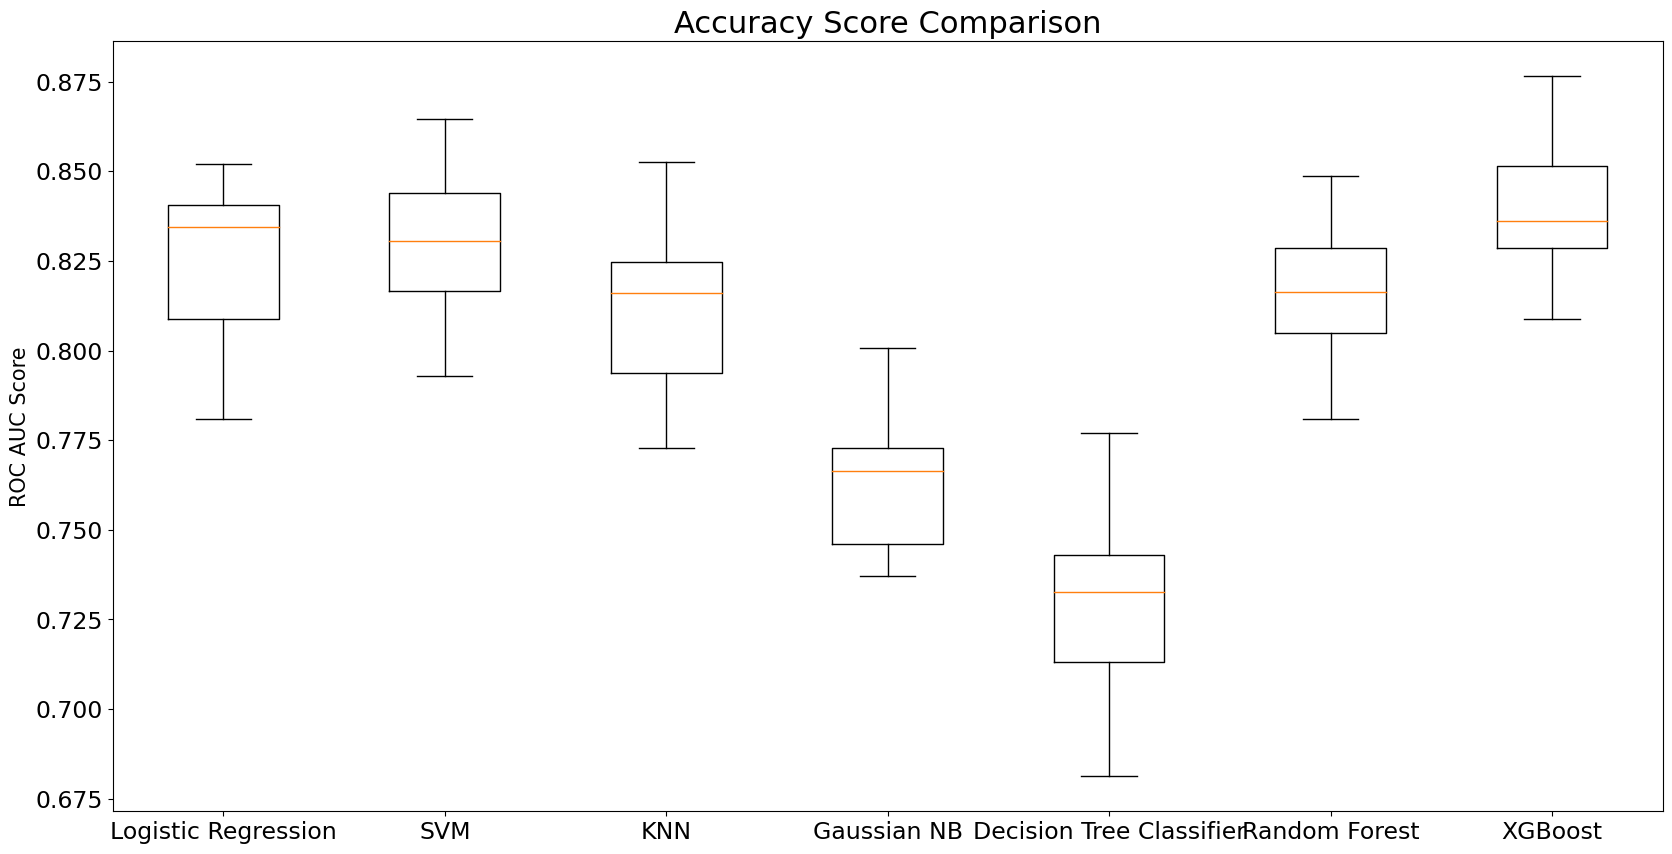

In [10]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
plt.boxplot(acc_results)
ax.set_xticklabels(names)
plt.ylabel('ROC AUC Score', fontsize = 15)
plt.title('Accuracy Score Comparison', fontsize = 22);

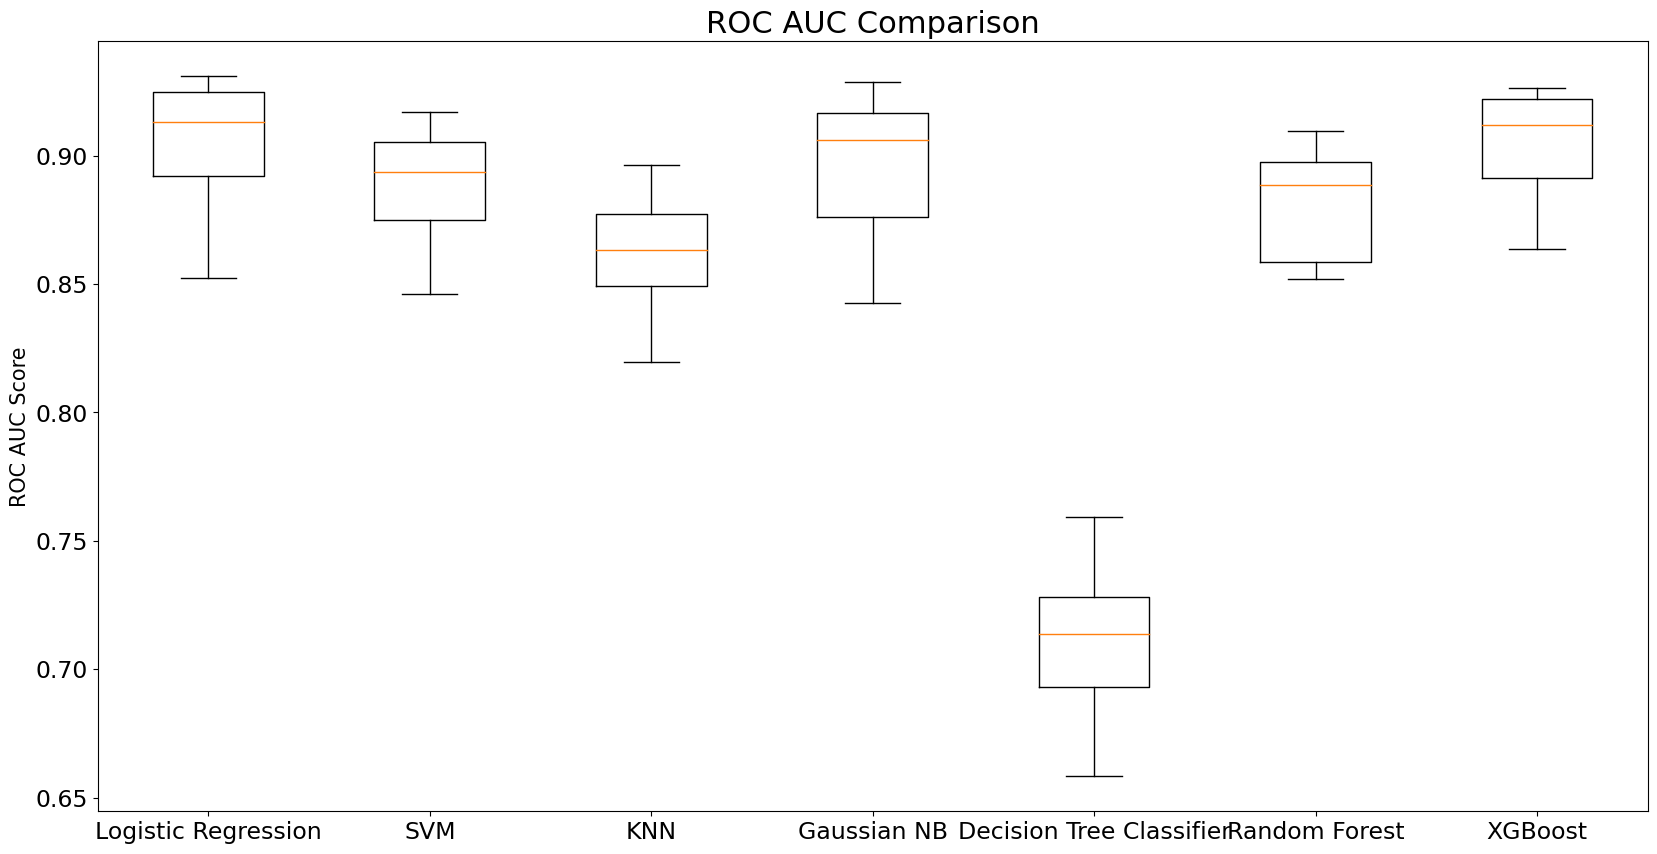

In [11]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
plt.boxplot(auc_results)
ax.set_xticklabels(names)
plt.ylabel('ROC AUC Score', fontsize = 15)
plt.title('ROC AUC Comparison', fontsize = 22);

<a href="#sommaire">Retour au sommaire</a>
# III. Optimisation des paramètres<a name="M3"></a>

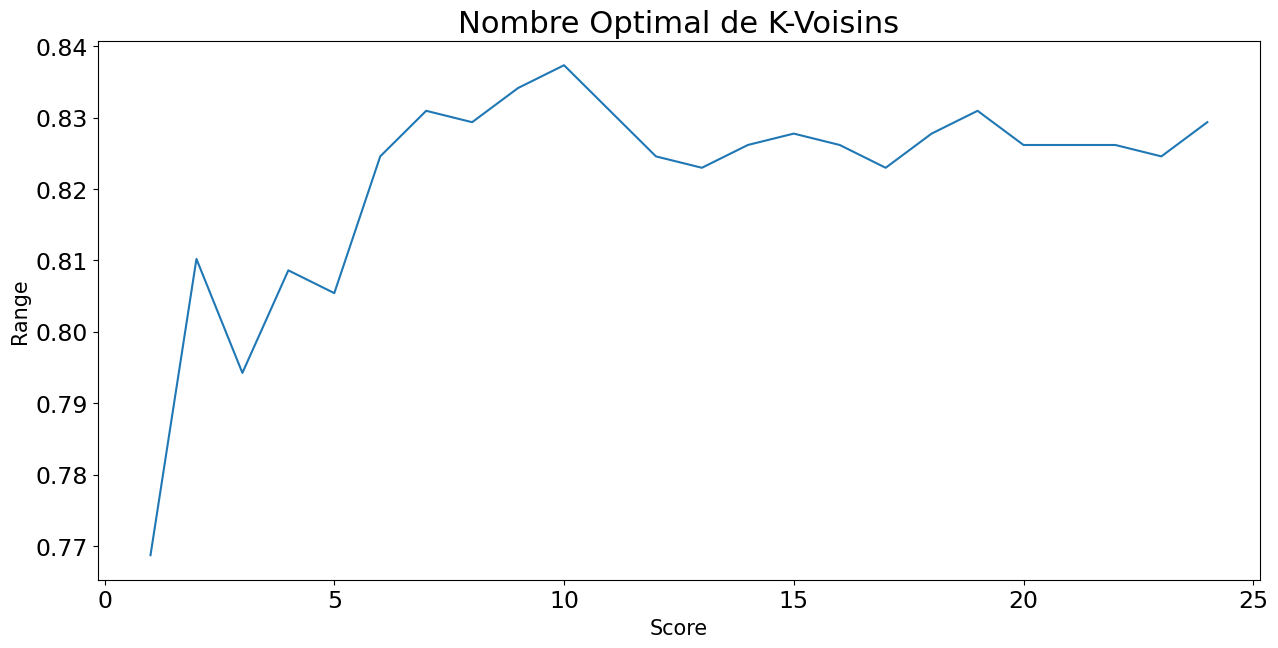

In [12]:
score_array = []
for each in range(1, 25):
    knn_loop = KNeighborsClassifier(n_neighbors = each)
    knn_loop.fit(X_train,y_train)
    score_array.append(knn_loop.score(X_test,y_test))
    
fig = plt.figure(figsize=(15, 7))
plt.plot(range(1,25),score_array)
plt.ylabel('Range', fontsize = 15)
plt.xlabel('Score', fontsize = 15)
plt.title('Nombre Optimal de K-Voisins', fontsize = 22);

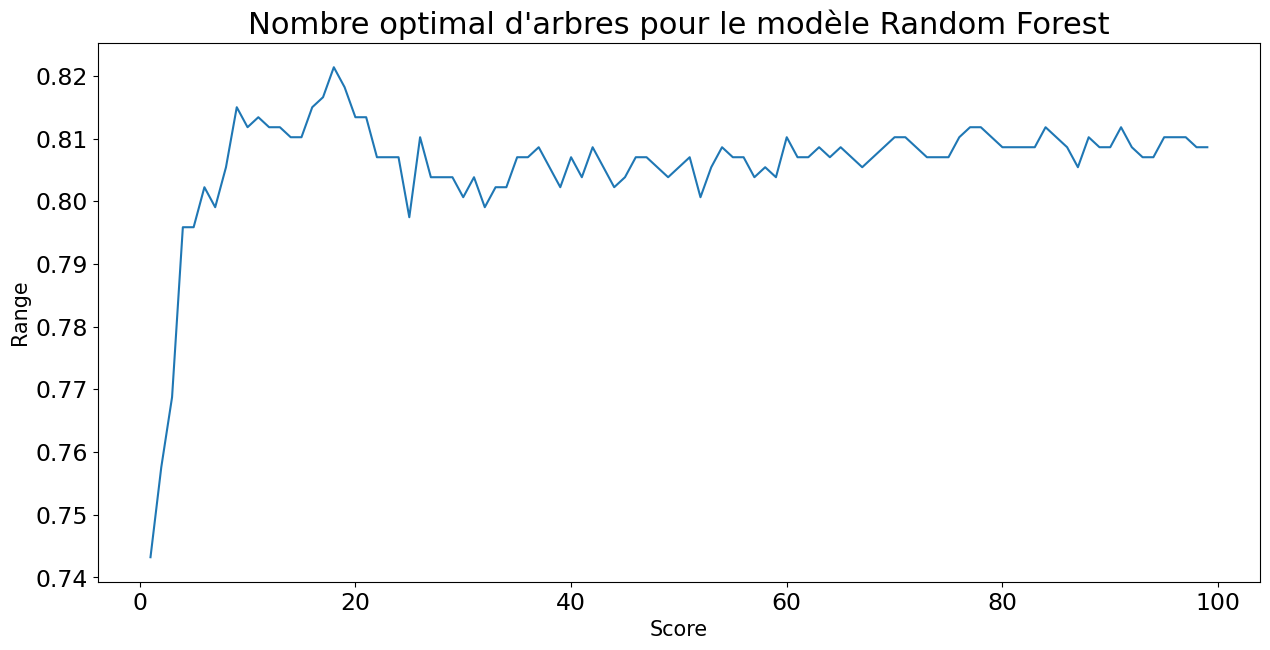

In [13]:
score_array = []
for each in range(1,100):
    rf_loop = RandomForestClassifier(n_estimators = each, random_state = 1)
    rf_loop.fit(X_train,y_train)
    score_array.append(rf_loop.score(X_test,y_test))

fig = plt.figure(figsize = (15, 7))
plt.plot(range(1,100),score_array)
plt.ylabel('Range', fontsize = 15)
plt.xlabel('Score', fontsize = 15)
plt.title("Nombre optimal d'arbres pour le modèle Random Forest", fontsize = 22);

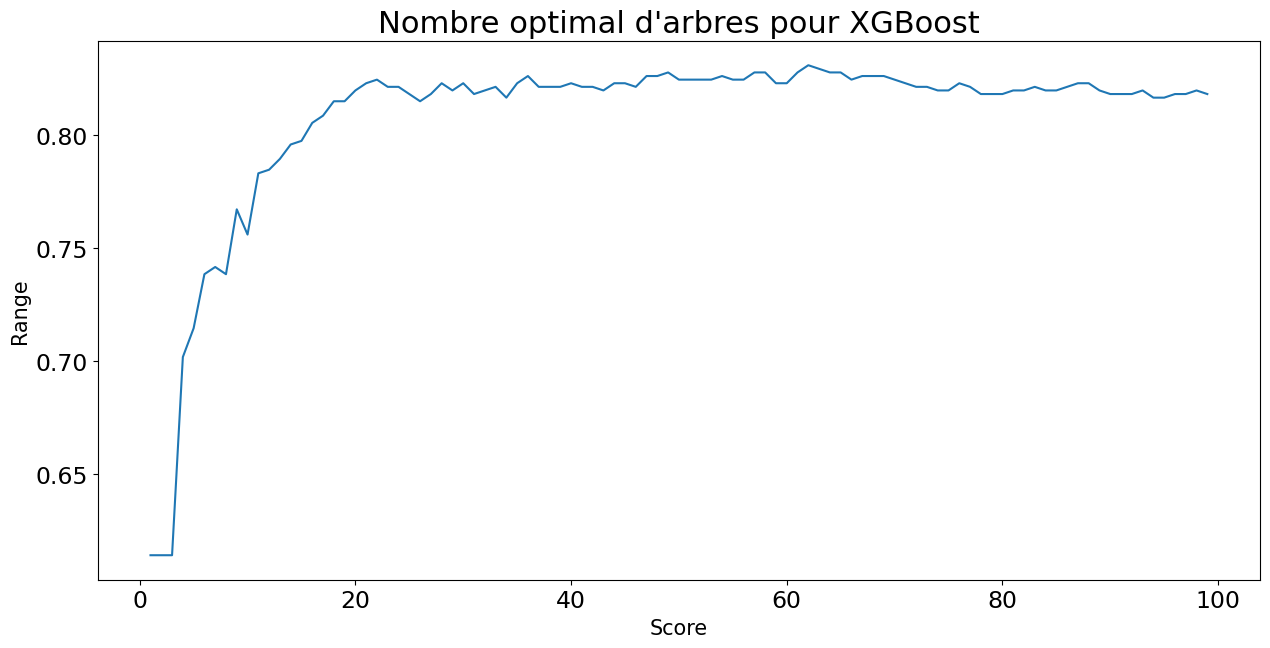

In [14]:
score_array = []
for each in range(1,100):
    gb_loop = GradientBoostingClassifier(n_estimators = each, random_state = 1)
    gb_loop.fit(X_train,y_train)
    score_array.append(gb_loop.score(X_test,y_test))

fig = plt.figure(figsize = (15, 7))
plt.plot(range(1,100),score_array)
plt.ylabel('Range', fontsize = 15)
plt.xlabel('Score', fontsize = 15)
plt.title("Nombre optimal d'arbres pour XGBoost", fontsize = 22);

<a href="#sommaire">Retour au sommaire</a>
# IV. Evaluation de la prédiction des modèles<a name="M4"></a>

In [15]:
tableau = pd.DataFrame()
def evaluate(algo, nom_algo):
    global tableau
    classifier = algo
    classifier.fit(X_train, y_train)
    # Prédiction des résultats du jeu de test:
    y_pred = classifier.predict(X_test)
    # Evaluation des résultats:
    acc = accuracy_score(y_test, y_pred )
    prec = precision_score(y_test, y_pred )
    rec = recall_score(y_test, y_pred )
    f1 = f1_score(y_test, y_pred )
    results = pd.DataFrame([[nom_algo, acc, prec, rec, f1]],
                           columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
    tableau = pd.concat([tableau, results], axis = 0)
    tableau = tableau.sort_values(["Recall", "Precision", "F1 Score"], ascending = False)
    tableau.reset_index(drop = True, inplace = True)
    return tableau

In [16]:
evaluate(LogisticRegression(random_state = 0), 'Logistic Regression')
evaluate(KNeighborsClassifier(n_neighbors = 10, metric = 'minkowski', p = 2), 'K-Nearest Neighbours')
evaluate(SVC(kernel = 'rbf', random_state = 0), 'SVM')
evaluate(GaussianNB(), 'Naive Bayes')
evaluate(DecisionTreeClassifier(criterion = 'entropy', random_state = 0), 'Decision Tree')
evaluate(RandomForestClassifier(n_estimators = 20, criterion = 'entropy', random_state = 0), 'Random Forest')
evaluate(GradientBoostingClassifier(n_estimators = 62, random_state = 0), 'XGBoost')

,Model,Accuracy,Precision,Recall,F1 Score
0,XGBoost,0.830941,0.817757,0.723140,0.767544
1,Logistic Regression,0.827751,0.816038,0.714876,0.762115
2,Random Forest,0.810207,0.783410,0.702479,0.740741
3,K-Nearest Neighbours,0.837321,0.853535,0.698347,0.768182
4,SVM,0.834131,0.855670,0.685950,0.761468
5,Decision Tree,0.714514,0.630705,0.628099,0.629400
6,Naive Bayes,0.773525,1.000000,0.413223,0.584795


In [17]:
classifier = GradientBoostingClassifier(random_state = 0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
acc = accuracy_score(y_test, y_pred )
prec = precision_score(y_test, y_pred )
rec = recall_score(y_test, y_pred )
f1 = f1_score(y_test, y_pred )
results = pd.DataFrame([['XGBoost Classifier', acc, prec, rec, f1]],
                       columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
print (results)

                Model  Accuracy  Precision    Recall  F1 Score
0  XGBoost Classifier  0.819777   0.794521  0.719008  0.754881


Test Data Accuracy: 0.8198


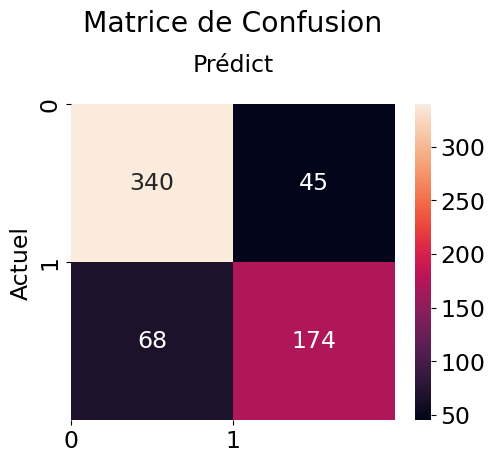

In [18]:
cm = confusion_matrix(y_test, y_pred) 
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
fig, ax = plt.subplots(figsize = (5, 4))
sn.heatmap(df_cm, annot = True, fmt = 'g', ax = ax)
class_names = [0, 1]
tick_marks = np.arange(len(class_names))
plt.tight_layout()
plt.title('Matrice de Confusion\n', y = 1.1)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
ax.xaxis.set_label_position("top")
plt.ylabel('Actuel')
plt.xlabel('Prédict\n')
print("Test Data Accuracy: %0.4f" % accuracy_score(y_test, y_pred));

In [19]:
classifier.fit(X_train, y_train) 
probs = classifier.predict_proba(X_test) 
probs = probs[:, 1] 
classifier_roc_auc = accuracy_score(y_test, y_pred )
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])

XGBoost Classifier (area = 0.82)


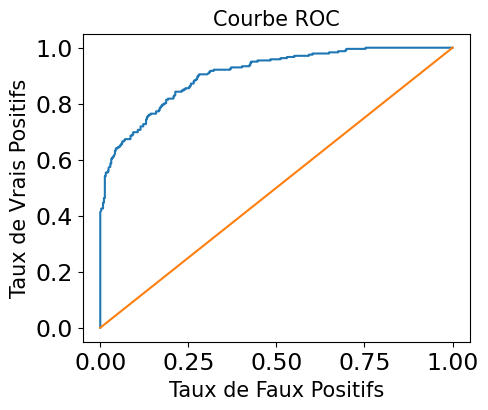

In [20]:
plt.figure(figsize=(5, 4))
plt.plot(rf_fpr, rf_tpr)
plt.plot([0,1], [0,1])
plt.ylabel('Taux de Vrais Positifs', fontsize = 15)
plt.xlabel('Taux de Faux Positifs', fontsize = 15)
plt.title('Courbe ROC', fontsize = 15)
#print('Logistic Regression (area = %0.2f)' % classifier_roc_auc);
print('XGBoost Classifier (area = %0.2f)' % classifier_roc_auc);

<a href="#sommaire">Retour au sommaire</a>
# V. Calcul du scoring<a name="M5"></a>

In [21]:
# Prédiction des résultats du jeu de test
y_pred = classifier.predict(X_test)

# Score de probabilité
y_pred_probs = classifier.predict_proba(X_test)
y_pred_probs  = y_pred_probs[:, 1]

In [22]:
final = pd.concat([test_identite, y_test], axis = 1).dropna()
final['predictions'] = y_pred
final['score (%)'] = (y_pred_probs*100).round(2)
final = final[['id_client', 'churn', 'predictions', 'score (%)']]
final['rank'] = pd.qcut(final['score (%)'].rank(method = 'first'), 10, labels = range(10, 0, -1))
final

,id_client,churn,predictions,score (%),rank
2339,5495,1,0,38.44,5
437,618,0,0,2.49,10
1316,25,0,0,13.21,7
573,7025,0,0,25.34,6
781,5414,1,0,24.87,6
...,...,...,...,...,...
1857,4078,1,0,7.68,9
304,5844,0,0,16.43,7
169,6359,0,0,14.43,7
2452,1309,1,0,28.96,6
